# Workbench

This notebook is intended to test written objects by attempt to build and optimize simple Organic Rankine Cycle (ORC).

Brief description of ORC:

https://en.wikipedia.org/wiki/Organic_Rankine_cycle

In [1]:
# Importing the most important packages
import time
import CoolProp.CoolProp as CP
from scipy.optimize import fsolve, fminbound, least_squares, differential_evolution, shgo, brute

# Importing OOPS elements
from OOPS import Turbine, Pump, HeatExchanger

In [2]:
Turbine(T_in = 211.80,p_in = 845,p_out = 20, mf = 0.395, medium = 'Toluene')

# Finding the right `T_hot_out` for heat exchanger
# Method 1 - `while` loop

Checking if it is possible to optimize desired premilimary parameters of heat exchanger using for loop

In [3]:
# Setting flue gas composition
z_CO2 = 0.0670
z_O2  = 0.0610
z_H2O = 0.1310
z_N2  = 0.7410

In [4]:
# Establishing object based on HeatExchanger class. I'm looking for outlet temperature of hotter fluid, 
# so I have to give some placeholder value

test_HE2 = HeatExchanger(T_hot_in = 510, T_hot_out = 100, T_cold_in = 182.24, T_cold_out = 310, 
                                  m_hot = 0.65, m_cold = 0.71895, p_hot_in = 100, p_cold_in = 300, 
                                  hot_fluid = f'HEOS::CO2[{z_CO2}]&O2[{z_O2}]&N2[{z_N2}]&H2O[{z_H2O}]', cold_fluid = 'INCOMP::T66', 
                                  flow_arrangement = 'counter')

In [5]:
# Check if parameters are in place
test_HE2.T_hot_out

100

In [6]:
# Calculating - first attempt
test_HE2.calc_temp_dist()

In [7]:
# Calculating satyration temperature of flue gas - this is lower bound of the T_hot_out temperature
T_dp = CP.PropsSI('T', 'Q', 1.0, 'P', test_HE2.p_hot_in*1000, test_HE2.hot_fluid)-273.15
T_dp

51.146850664248575

In [8]:
# Checking the value of dT_min
test_HE2.dT_min

-21.663065238738284

Text(0.5, 1.0, 'Test HE2')

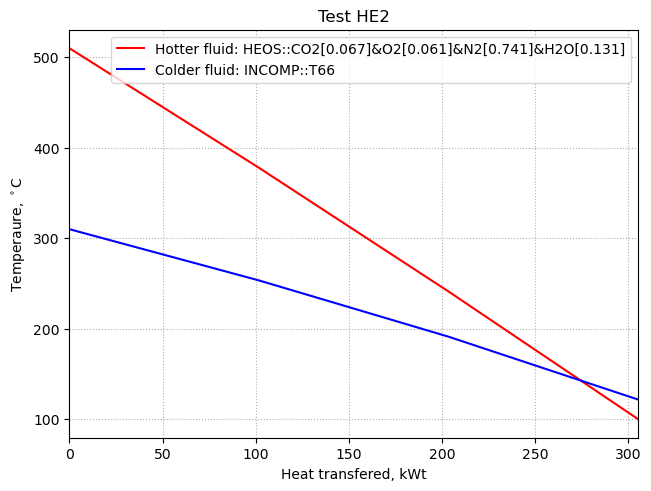

In [9]:
# Let's check how it looks on a diagram
test_HE2_fig, test_HE2_ax = test_HE2.plot_temp_dist_df()
test_HE2_ax.set_title('Test HE2')

The value of `dT_min` is rubbish - thats OK ;) for now. Now I need to find `T_hot_out` using `while` loop.  
From the diagram it is visible that `T_hot_out` should go up for `dT_min` to be positive in the first place and then to reach desired 40 C.deg 

In [10]:
start_time = time.time()

while round(test_HE2.dT_min,2) != 40:
    
    test_HE2.T_hot_out = test_HE2.T_hot_out+0.01
    test_HE2.calc_temp_dist()
    test_HE2.dT_min
    print(test_HE2.T_hot_out, test_HE2.dT_min, end="\r")

end_time = time.time()

In [11]:
# How long did it take?
hours, rem = divmod(end_time-start_time, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:01:37.36


Text(0.5, 1.0, 'Test HE2')

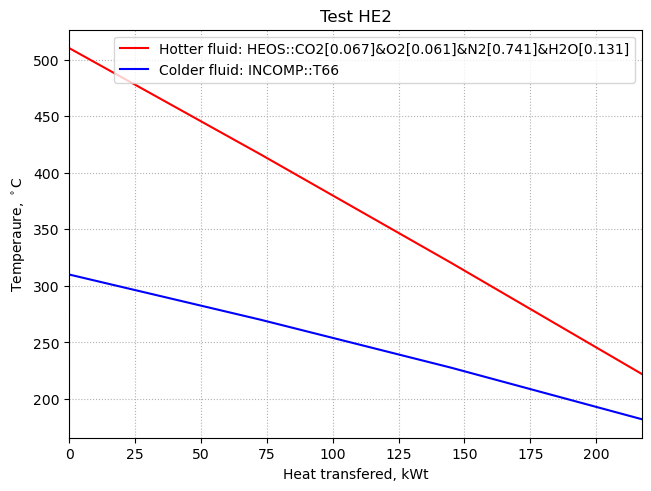

In [12]:
# Now let's chec the diagram again 
# Let's check how it looks on a diagram
test_HE2_fig, test_HE2_ax = test_HE2.plot_temp_dist_df()
test_HE2_ax.set_title('Test HE2')

So it is possible to find the right `T_hot_out` using while loop, although it takes some time. There has to be other, faster method to do the same calculations eg. usning *SciPy* package.

# Finding the right `T_hot_out` for heat exchanger
# Method 2 - wrapper function

Method 1 is simple but takes a lot of time.

It also requires to know if step value should be added or subtracted. In theory is should be easy to fix with simple `if` statement, but in reality cases with phase change will make it much more tricky.

Method 2 uses **simple wrapper function** of object to make it possible to combine with *SciPy* packgage.

In [13]:
# First lets define new object, to not interfere with calulations for Method 1

test_HE3 = HeatExchanger(T_hot_in = 510, T_hot_out = 100, T_cold_in = 182.24, T_cold_out = 310, 
                                  m_hot = 0.65, m_cold = 0.71895, p_hot_in = 100, p_cold_in = 300, 
                                  hot_fluid = f'HEOS::CO2[{z_CO2}]&O2[{z_O2}]&N2[{z_N2}]&H2O[{z_H2O}]', cold_fluid = 'INCOMP::T66', 
                                  flow_arrangement = 'counter')

In [14]:
# Wrapper for SciPy

def solve_T_hot_out(T_hot_out, dT_min, Object):
    
    """
    T_hot_out - temperature of hotter fluid at heat exchanger outlet to be found, C
    dT_min - desired design value of minimal temperatur difference in heat exchanger, C
    Object - object to be updated during calculations in function
    """
    
    test_HE3.T_hot_out = T_hot_out
    test_HE3.calc_temp_dist()
    
    return test_HE3.dT_min - dT_min #The difference between this two values should be 0
    

In [15]:
# Finding the reight outlet temperature of hotter fluid T_hot_out

T_hot_out = least_squares(fun=solve_T_hot_out, x0=100, bounds = (T_dp, test_HE3.T_hot_in), args = ([40,test_HE3]))

In [16]:
# Compare resulst from method 1 and 2
print('Method 1: ', test_HE2.T_hot_out, ' Method 2: ', T_hot_out.x)

Method 1:  222.2399999999286  Method 2:  [222.24012597]


In [17]:
test_HE3.dT_min

40.000001735197884

There is slight difference, but for industrial applications the difference at the second decimal is negletible. The most important part is that calcualtions using method 2 are much faster - the result is obtained almost instantly

Text(0.5, 1.0, 'Test HE3')

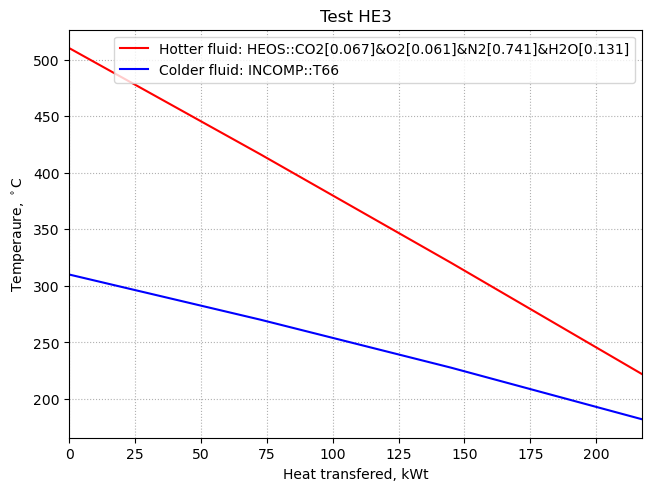

In [85]:
# Now let's chec the diagram
test_HE3_fig, test_HE3_ax = test_HE3.plot_temp_dist_df()
test_HE3_ax.set_title('Test HE3')

# Method 3

Is there a way to write method for object that would be feasible for any SciPy funtions?